# Preprocessing Tabular Data

## Handling Missing Values
+ Identify patterns of missing data (MCAR, MAR, MNAR).
+ Apply appropriate imputation techniques (mean, median, mode, forward/backward fill, K-NN imputation).
+ Compare the impact of different imputation strategies on data quality and distribution.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

RMSE Mean Imputation    : 148.2711
RMSE Forward Fill       : 225.2179
RMSE Backward Fill      : 204.5845


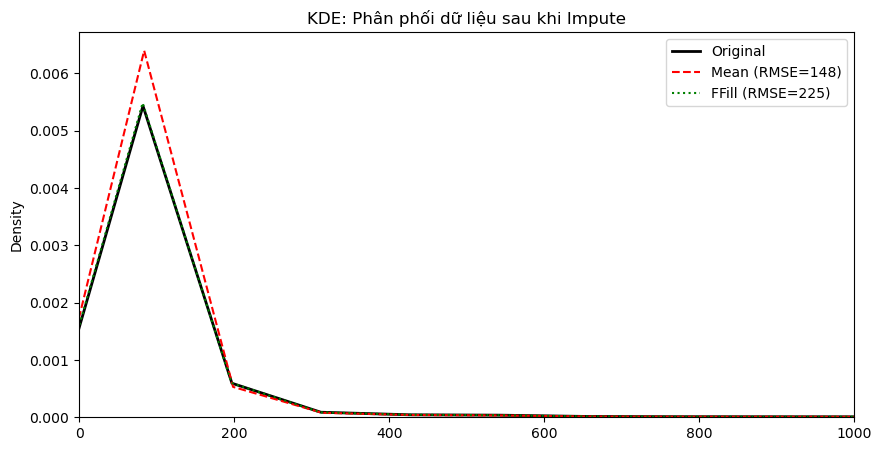

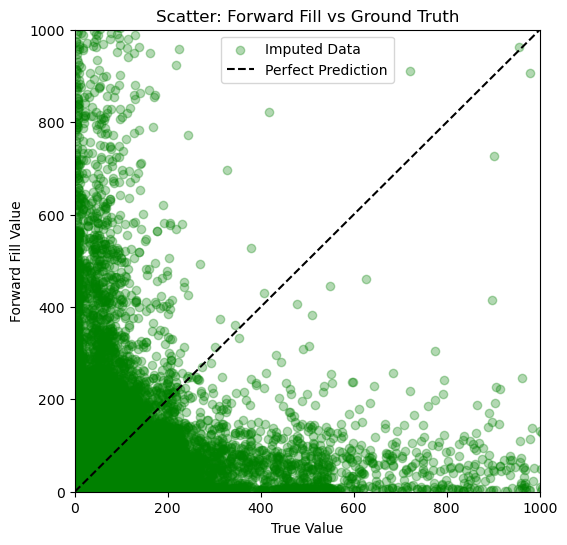

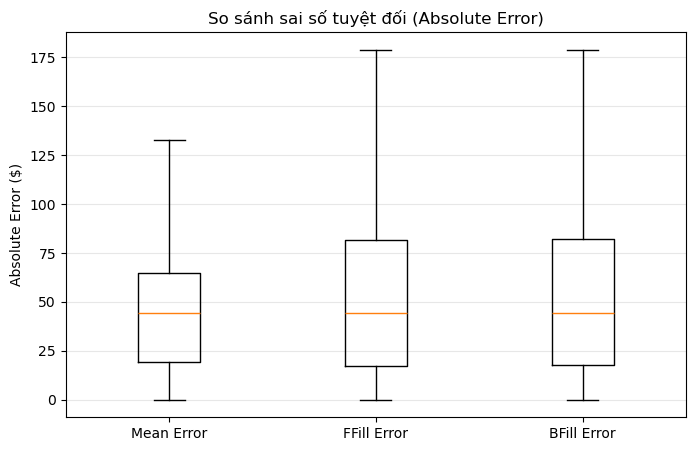

In [ ]:
# =========================
#        LOAD DATA
# =========================
dataTrain = pd.read_csv('../data/tabular/fraudTrain.csv')
dataTest  = pd.read_csv('../data/tabular/fraudTest.csv')

# Chỉ giữ các cột cần thiết
dataTest = dataTest[['trans_date_trans_time', 'amt']].copy()
dataTrain = dataTrain[['amt']].copy()

# Chuyển time về datetime
dataTest['trans_date_trans_time'] = pd.to_datetime(
    dataTest['trans_date_trans_time']
)

# =========================
#   TẠO MISSING DATA (MCAR)
# =========================
def make_missing(series, fraction=0.1, random_state=42):
    """
    Tạo missing values theo cơ chế MCAR cho pandas Series
    """
    rng = np.random.default_rng(random_state)
    n_missing = int(len(series) * fraction)
    missing_idx = rng.choice(series.index, n_missing, replace=False)

    series_missing = series.copy()
    series_missing.loc[missing_idx] = np.nan
    return series_missing, missing_idx

# # Ground truth
# amtTest_true = dataTest['amt'].values.reshape(-1, 1)

# Tạo thêm cột amt_missing cho dataTest
dataTest['amt_missing'], missing_idx = make_missing(
    dataTest['amt'], fraction=0.1
)

# maskTest = dataTest['amt_missing'].isna().values # mask cho missing

# =========================
# FORWARD / BACKWARD FILL
# =========================
# Sort theo thời gian (CỰC KỲ QUAN TRỌNG)
dataTest_sorted = dataTest.sort_values('trans_date_trans_time').reset_index(drop=True) # reset index sau khi sort, mục đích là để khớp thứ tự khi đánh giá bằng RMSE

# Biến mask cũng phải lấy từ dataTest_sorted
mask_sorted = dataTest_sorted['amt_missing'].isna().values

# 1. Forward / Backward Fill
amt_ffill = dataTest_sorted['amt_missing'].ffill().bfill().values.reshape(-1, 1)
amt_bfill = dataTest_sorted['amt_missing'].bfill().ffill().values.reshape(-1, 1)

# 2. Mean Imputation
mean_imputer = SimpleImputer(strategy='mean')
mean_imputer.fit(dataTrain[['amt']].values) # Fit trên Train gốc
# Transform trên dataTest_sorted
amt_mean = mean_imputer.transform(dataTest_sorted[['amt_missing']].values)

# =========================
# EVALUATION & ERROR CALCULATION
# ================================

# Lưu lại ground truth sau khi sort để khớp thứ tự
amt_true_sorted = dataTest_sorted['amt'].values.reshape(-1, 1) # ground truth sau khi sort

# Tính Error (Tuyệt đối) để vẽ Boxplot
error_mean = np.abs(amt_true_sorted[mask_sorted] - amt_mean[mask_sorted])
error_ffill = np.abs(amt_true_sorted[mask_sorted] - amt_ffill[mask_sorted])
error_bfill = np.abs(amt_true_sorted[mask_sorted] - amt_bfill[mask_sorted])

rmse_mean = np.sqrt(mean_squared_error(amt_true_sorted[mask_sorted], amt_mean[mask_sorted]))
rmse_ffill = np.sqrt(mean_squared_error(amt_true_sorted[mask_sorted], amt_ffill[mask_sorted]))
rmse_bfill = np.sqrt(mean_squared_error(amt_true_sorted[mask_sorted], amt_bfill[mask_sorted]))


print(f'RMSE Mean Imputation    : {rmse_mean:.4f}')
print(f'RMSE Forward Fill       : {rmse_ffill:.4f}')
print(f'RMSE Backward Fill      : {rmse_bfill:.4f}')


# =========================
#      VISUALIZATION
# =========================
# 1. KDE PLOT
plt.figure(figsize=(10, 5))
sns.kdeplot(amt_true_sorted.ravel(), label='Original', color='k', linewidth=2)
sns.kdeplot(amt_mean.ravel(), label=f'Mean (RMSE={rmse_mean:.0f})', linestyle='--', color='r')
sns.kdeplot(amt_ffill.ravel(), label=f'FFill (RMSE={rmse_ffill:.0f})', linestyle=':', color='g')
plt.title('KDE: Phân phối dữ liệu sau khi Impute')
plt.xlim(0, 1000)
plt.legend()
plt.show()

# 2. SCATTER PLOT (Thay đổi: Vẽ Forward Fill thay vì Mean)
plt.figure(figsize=(6, 6))
# Vẽ các điểm tại vị trí missing
plt.scatter(amt_true_sorted[mask_sorted], amt_ffill[mask_sorted], alpha=0.3, label='Imputed Data', color='green')
plt.plot([0, 1000], [0, 1000], 'k--', label='Perfect Prediction') # Đường chéo 45 độ
plt.title('Scatter: Forward Fill vs Ground Truth')
plt.xlabel('True Value')
plt.ylabel('Forward Fill Value')
plt.xlim(0, 1000); plt.ylim(0, 1000)
plt.legend()
plt.show()

# 3. BOX PLOT 
plt.figure(figsize=(8, 5))
# Vẽ log error nếu sai số quá chênh lệch, hoặc vẽ raw error
plt.boxplot([error_mean.ravel(), error_ffill.ravel(), error_bfill.ravel()], 
            # labels=['Mean Error', 'FFill Error', 'BFill Error'], 
            tick_labels=['Mean Error', 'FFill Error', 'BFill Error'],
            showfliers=False) # Ẩn outliers để dễ nhìn hộp
plt.title('So sánh sai số tuyệt đối (Absolute Error)')
plt.ylabel('Absolute Error ($)')
plt.grid(axis='y', alpha=0.3)
plt.show()



## Data Normalization
+ Apply Min-Max scaling, standardization (Z-score normalization), and robust scaling for data with outliers.
+ Compare distributions before and after normalization using appropriate visualizations.

In [ ]:
# Data Normalization
# Implement Min-Max scaling, standardization (Z-score normalization), and robust scaling.
# Compare distributions before and after normalization using appropriate visualizations.

## Categorical Encoding
+ Identify categorical variables requiring encoding.
+ Apply suitable encoding for each type of categorical variable, such as one-hot encoding for nominal variables and ordinal encoding for ordinal variables.
+ Discuss strategies for handling high-cardinality categorical features.


In [ ]:
# Categorical Encoding
# Identify categorical variables requiring encoding.
# Apply one-hot encoding for nominal variables and ordinal encoding for ordinal variables.
# Discuss strategies for handling high-cardinality categorical features.

## Feature Selection
+ Choose a suitable feature selection method.
+ Calculate the correlation matrix, use variance threshold, apply feature importance from tree-based models, or implement recursive feature elimination (RFE).
+ Compare the selected feature sets and justify your final selection.

In [ ]:
# Feature Selection
# Choose a suitable feature selection method.
# Calculate the correlation matrix, use variance threshold, apply feature importance from tree-based models, or implement recursive feature elimination (RFE).
# Compare the selected feature sets and justify your final selection.